<a href="https://colab.research.google.com/github/davidenko2000/LoFTR_stereo/blob/master/LoFTR_evaluation2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LoFTR evaluation on KITTI dataset

KITTI dataset consists of 200 stereo images (left and right).
Below you can find results of LoFTR matcher on such dataset.


In [ ]:
# Configure environment and grab LoFTR code.
!rm -rf sample_data
!pip install torch einops yacs kornia
!git clone https://github.com/zju3dv/LoFTR --depth 1
!mv LoFTR/* . && rm -rf LoFTR

# Download pretrained weights
!mkdir weights 
%cd weights/
#!gdown --id 1w1Qhea3WLRMS81Vod_k5rxS_GNRgIi-O  # indoor-ds
!gdown --id 1M-VD35-qdB5Iw-AtbDBCKC7hPolFW9UY  # outdoor-ds
%cd ..

In [2]:
import torch
import cv2
import numpy as np
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import matplotlib.colors as colors

!pip install einops
!pip install kornia
!pip install yacs
!pip install loguru
import sys
sys.path.append('/content/drive/MyDrive/LoFTR')
from src.utils.plotting import make_matching_figure
from src.loftr import LoFTR, default_cfg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 24.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.1 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
"""Method to plot image using real disparity map and computed disparity map"""
def plot_acc_byimage(idx, model):
  real_disp = skimage.util.img_as_ubyte(mpimg.imread(f"/content/drive/MyDrive/LoFTR/data/kitti/disparity/{str.zfill(str(idx), 6)}_10.png"))
  real_disp = cv2.resize(real_disp, (1240, 375))
  predicted_disp = compute_disparity_map(idx, model)
  acc = disparity_accuracy_byimage(real_disp=real_disp, predicted_disp=predicted_disp)

  plt.figure(figsize=(20, 10))
  color_map = colors.ListedColormap(['black', 'red', 'yellow'])
  plt.imshow(acc, cmap=color_map)
 

"""
Function which uses real disparity, predicted disparity and pixel error to calcuate accuracy of prediction.
Returns:
        -1 -> if the real disparity is unknown
        0  -> if the prediction in incorrect
        1  -> if the prediction is correct (the prediction must be in the interval which uses allowed pixel error
"""
def disparity_accuracy_byimage(real_disp, predicted_disp, pxl_error=3):
	acc = np.zeros(predicted_disp.shape)
	acc[predicted_disp == 0] = -1
	acc[(predicted_disp != 0) & (np.abs(predicted_disp - real_disp) < pxl_error)] = 1

	return acc

"""
Function which computes disparity map using model and index (idx) of an image.
"""
def compute_disparity_map(idx, model):
  img0_raw = cv2.imread(f"/content/drive/MyDrive/LoFTR/data/kitti/RGB/left/{str.zfill(str(idx), 6)}_10.png", cv2.IMREAD_GRAYSCALE)
  img1_raw = cv2.imread(f"/content/drive/MyDrive/LoFTR/data/kitti/RGB/right/{str.zfill(str(idx), 6)}_10.png", cv2.IMREAD_GRAYSCALE)
  
  if img0_raw is None:
    print('Wrong path:')
  else:
    img0_raw = cv2.resize(img0_raw, (1240, 375))
    img1_raw = cv2.resize(img1_raw, (1240, 375))

  img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
  img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
  batch = {'image0': img0, 'image1': img1}
  
  predicted_disp = np.zeros(img0_raw.shape)

  # Inference with LoFTR and get prediction
  with torch.no_grad():
      matcher(batch)
      mkpts0 = batch['mkpts0_f'].cpu().numpy()
      mkpts1 = batch['mkpts1_f'].cpu().numpy()
      mconf = batch['mconf'].cpu().numpy()

  for i in range(mkpts0.shape[0]):
    disp = mkpts0[i][0] - mkpts1[i][0] #check only on epipolar line
    predicted_disp[int(mkpts0[i][1])][int(mkpts0[i][0])] = disp

  return predicted_disp


2023-05-29 20:53:37.927 | WARNING  | src.loftr.utils.coarse_matching:get_coarse_match:246 - Number of matches:5361
2023-05-29 20:53:38.679 | WARNING  | src.loftr.utils.coarse_matching:get_coarse_match:246 - Number of matches:2905


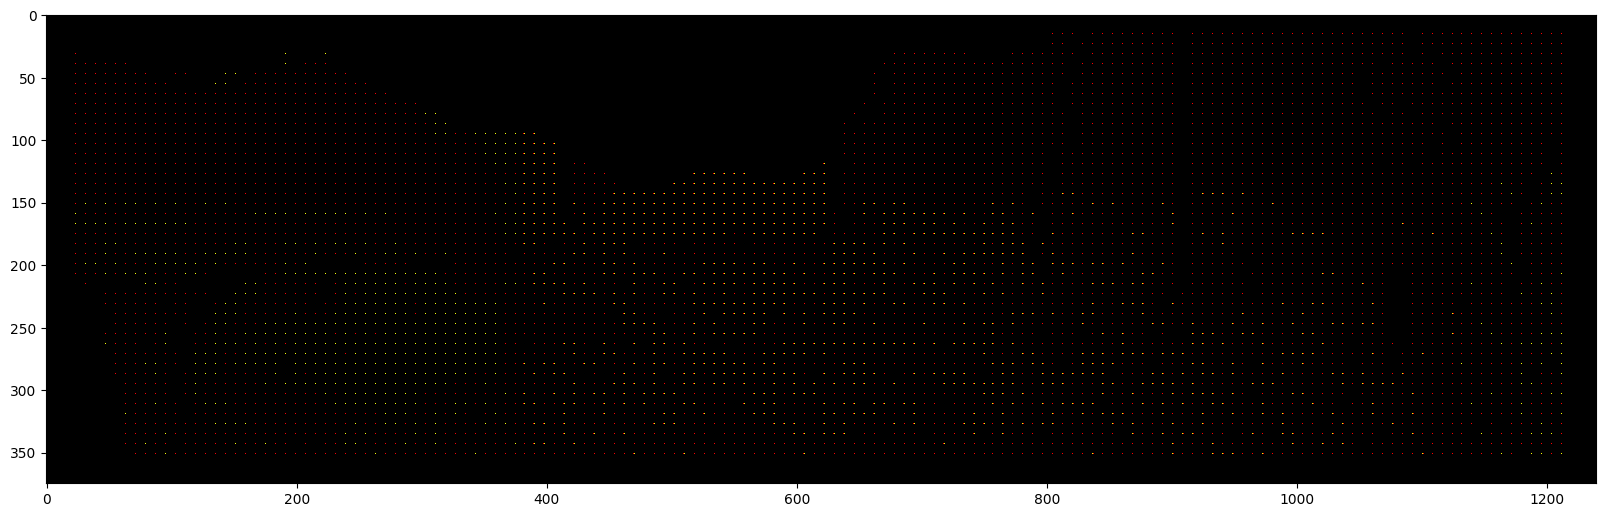

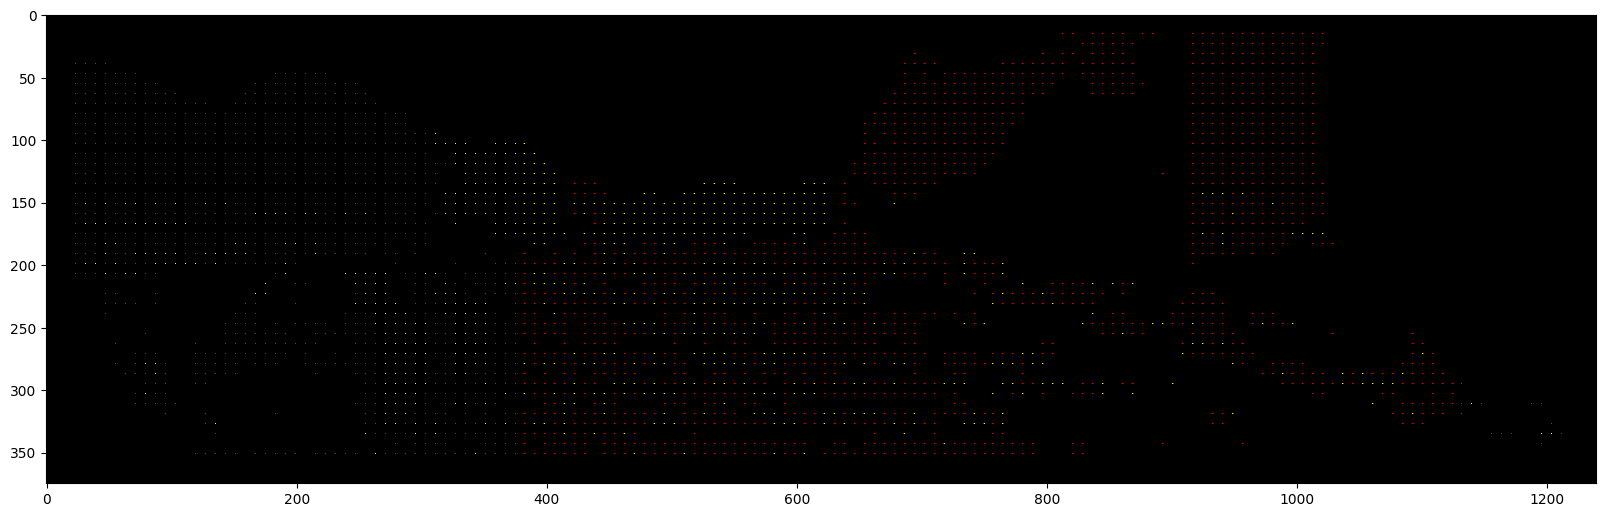

In [15]:
from re import M
import skimage
from matplotlib import image as mpimg

matcher = LoFTR(config=default_cfg)
ckpts = [
  "/content/drive/MyDrive/LoFTR/data/kitti/outdoor_ds.ckpt",
  "/content/drive/MyDrive/LoFTR/logs/tb_logs/outdoor-kitti-1248x376/version_13/checkpoints/epoch=92-auc@5=0.883-auc@10=0.942-auc@20=0.971.ckpt"
]

metrics = []
for ckpt in ckpts:
  matcher.load_state_dict(torch.load(ckpt)['state_dict'])
  matcher = matcher.eval().cuda()

  """max_N = 200
  counter_correct = 0
  counter_total = 0
  pxl_error = 3
  by_error=[]
  for pxl_error in [3]:

    for idx in range(140, 200):
      real_disp = skimage.util.img_as_ubyte(mpimg.imread(f"/content/drive/MyDrive/LoFTR/data/kitti/disparity/{str.zfill(str(idx), 6)}_10.png"))
      real_disp = cv2.resize(real_disp, (1240, 375))

      predicted_disp = compute_disparity_map(idx, matcher)
      counter_correct += np.count_nonzero((predicted_disp != 0) & (np.abs(predicted_disp - real_disp) < pxl_error))
      counter_total += np.count_nonzero(predicted_disp)

    by_error.append(counter_correct/counter_total)
  
  metrics.append(by_error)"""
  plot_acc_byimage(100, matcher)

#np.savetxt("/content/drive/MyDrive/LoFTR/data/kitti/metrics_outdoor_test.csv", np.array(metrics), delimiter=",")

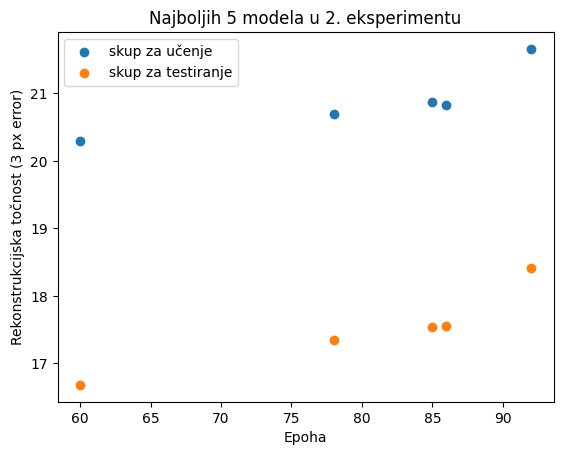

In [20]:
plt.title("Najboljih 5 modela u 2. eksperimentu")
plt.xlabel("Epoha")
plt.ylabel("Rekonstrukcijska točnost (3 px error)")
plt.scatter([60, 78, 85, 86, 92], [20.29, 20.70, 20.88, 20.83, 21.66], label="skup za učenje")
plt.scatter([60, 78, 85, 86, 92], [16.68, 17.35, 17.54, 17.56, 18.42], label="skup za testiranje")
plt.legend()

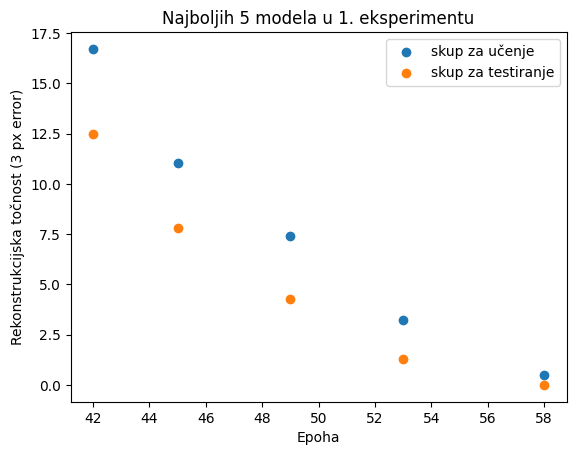

In [22]:
plt.title("Najboljih 5 modela u 1. eksperimentu")
plt.xlabel("Epoha")
plt.ylabel("Rekonstrukcijska točnost (3 px error)")
plt.scatter([42, 45, 49, 53, 58], [16.71, 11.03, 7.41, 3.25, 0.50], label="skup za učenje")
plt.scatter([42, 45, 49, 53, 58], [12.50, 7.81, 4.29, 1.28, 0.00], label="skup za testiranje")
plt.legend()